In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re


In [2]:
spark.stop()

NameError: name 'spark' is not defined

In [3]:
spark = SparkSession.builder \
    .appName("HDB") \
    .master("local[*]") \
    .getOrCreate()

print("Spark started successfully.")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/15 08:54:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark started successfully.


In [4]:
# -------------------------
# Read CSV
# -------------------------

path = "file:///home/user/data/HDB.csv" 

df = spark.read.csv(
    path,
    header=True,         # first row contains column names
    inferSchema=True     # attempts to infer column data types
)

print("HDB Data Row Count:", df.count(), "rows")
df.show(5)

HDB Data Row Count: 213666 rows
+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+
|              month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|   remaining_lease|resale_price|
+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+
|2017-01-01 00:00:00|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|61 years 04 months|    232000.0|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|60 years 07 months|    250000.0|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|62 years 05 months|    262000

In [ ]:
# -------------------------
# Check for missing values (null counts per column)
# -------------------------

df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|
+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|    0|   0|        0|    0|          0|           0|             0|         0|                  0|              0|           0|
+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+



In [ ]:
# -------------------------
# Describe all columns, including strings
# -------------------------
df.summary().show()

+-------+----------+----------------+------------------+------------+------------+-----------------+----------+-------------------+------------------+------------------+
|summary|      town|       flat_type|             block| street_name|storey_range|   floor_area_sqm|flat_model|lease_commence_date|   remaining_lease|      resale_price|
+-------+----------+----------------+------------------+------------+------------+-----------------+----------+-------------------+------------------+------------------+
|  count|    213666|          213666|            213666|      213666|      213666|           213666|    213666|             213666|            213666|            213666|
|   mean|      NULL|            NULL|345.50626826084255|        NULL|        NULL| 96.8363726563889|      NULL| 1996.3739574850467|              NULL|519222.49155027006|
| stddev|      NULL|            NULL|255.01554471137214|        NULL|        NULL|24.03127354294156|      NULL| 14.256916675138974|              NULL|

In [ ]:
# -------------------------
# No. of rows and columns
# -------------------------
rows = df.count()
cols = len(df.columns)
print(f"Shape: ({rows}, {cols})")

Shape: (213666, 11)


In [ ]:
# -------------------------
# Data Types
# -------------------------
print(df.dtypes)  # List of tuples (colName, dataType)

# Extract numerical year and month from 'month' string (eg. 2017-01) and convert to transaction_year and transaction_month
# Extract numerical remaining lease year and month from 'remaining_lease' (eg. )

[('month', 'timestamp'), ('town', 'string'), ('flat_type', 'string'), ('block', 'string'), ('street_name', 'string'), ('storey_range', 'string'), ('floor_area_sqm', 'double'), ('flat_model', 'string'), ('lease_commence_date', 'int'), ('remaining_lease', 'string'), ('resale_price', 'double')]


In [ ]:
# -------------------------
# List unique values for "flat_model", "flat_type", "storey_range"
# -------------------------

columns_to_check = ["flat_model", "flat_type", "storey_range"]

for column in columns_to_check:
    uniques = df.select(column).distinct().collect()
    unique_values = [row[column] for row in uniques]
    print(f"Unique values in '{column}' ({len(unique_values)} unique values):")
    print(unique_values)
    print()

# Map 'flat_type' and 'storey_range'
# One-hot encoding on 'town' and 'flat_model'

Unique values in 'flat_model' (21 unique values):
['Apartment', 'Premium Maisonette', 'Improved', 'Type S2', 'New Generation', 'Improved-Maisonette', 'Model A-Maisonette', 'Maisonette', 'Multi Generation', 'Model A', 'DBSS', 'Simplified', 'Terrace', 'Adjoined flat', 'Type S1', 'Standard', 'Premium Apartment', 'Model A2', 'Premium Apartment Loft', '2-room', '3Gen']

Unique values in 'flat_type' (7 unique values):
['3 ROOM', '1 ROOM', '4 ROOM', '2 ROOM', 'EXECUTIVE', '5 ROOM', 'MULTI-GENERATION']



Unique values in 'storey_range' (17 unique values):
['43 TO 45', '37 TO 39', '10 TO 12', '04 TO 06', '40 TO 42', '16 TO 18', '19 TO 21', '34 TO 36', '31 TO 33', '13 TO 15', '46 TO 48', '22 TO 24', '25 TO 27', '07 TO 09', '01 TO 03', '28 TO 30', '49 TO 51']



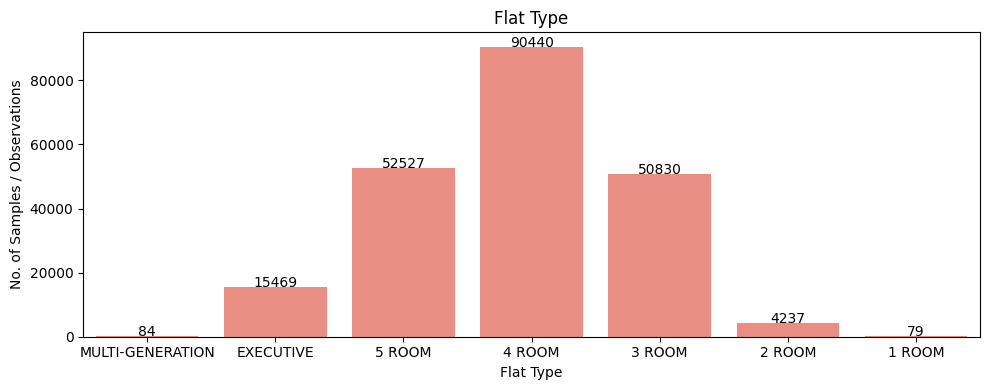

In [70]:
# -------------------------
# No. of Observations of Each Flat Type
# -------------------------

# Group and count by flat_type
flat_type_counts = df.groupBy("flat_type").count().orderBy("flat_type", ascending=False)

# Convert to Pandas for plotting
flat_type_pd = flat_type_counts.toPandas()

# Plot
plt.figure(figsize=(10, 4))
ax = sns.barplot(
    x="flat_type",
    y="count",
    data=flat_type_pd,
    color="salmon"
)

plt.title("Flat Type")
plt.xlabel("Flat Type")
plt.ylabel("No. of Samples / Observations")

# Add value labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 50,  # adjust spacing above bars
        f"{int(height)}",
        ha="center"
    )

plt.tight_layout()
plt.show()

# Observations
# Larger representation of 4 ROOM in the dataset, followed by 5 ROOM and 3 ROOM


In [5]:

# -------------------------
# Mapping: flat_type
# -------------------------
flat_type_mapping_expr = (
    F.when(F.col("flat_type") == "1 ROOM", 1)
     .when(F.col("flat_type") == "2 ROOM", 2)
     .when(F.col("flat_type") == "3 ROOM", 3)
     .when(F.col("flat_type") == "4 ROOM", 4)
     .when(F.col("flat_type") == "5 ROOM", 5)
     .when(F.col("flat_type") == "EXECUTIVE", 6)
     .when(F.col("flat_type") == "MULTI-GENERATION", 7)
     .otherwise(None)
)

# -------------------------
# Mapping: storey_range
# -------------------------
storey_range_mapping_expr = (
    F.when(F.col("storey_range") == "01 TO 03", 1)
     .when(F.col("storey_range") == "04 TO 06", 2)
     .when(F.col("storey_range") == "07 TO 09", 3)
     .when(F.col("storey_range") == "10 TO 12", 4)
     .when(F.col("storey_range") == "13 TO 15", 5)
     .when(F.col("storey_range") == "16 TO 18", 6)
     .when(F.col("storey_range") == "19 TO 21", 7)
     .when(F.col("storey_range") == "22 TO 24", 8)
     .when(F.col("storey_range") == "25 TO 27", 9)
     .when(F.col("storey_range") == "28 TO 30", 10)
     .when(F.col("storey_range") == "31 TO 33", 11)
     .when(F.col("storey_range") == "34 TO 36", 12)
     .when(F.col("storey_range") == "37 TO 39", 13)
     .when(F.col("storey_range") == "40 TO 42", 14)
     .when(F.col("storey_range") == "43 TO 45", 15)
     .when(F.col("storey_range") == "46 TO 48", 16)
     .when(F.col("storey_range") == "49 TO 51", 17)
     .otherwise(None)
)

# -------------------------
# Extract transaction year & month from 'month' column
# Example 'month' format: '12 years 5 months'
# -------------------------
extract_transaction_year = F.year(F.to_date(F.col("month"), "yyyy-MM"))
extract_transaction_month = F.month(F.to_date(F.col("month"), "yyyy-MM"))
extract_remaining_lease_year = F.regexp_extract(F.col("remaining_lease"), r"(\d+)\s+years?", 1).cast(IntegerType())

# -------------------------
# Apply transformations
# -------------------------
df = df.withColumn("flat_type", flat_type_mapping_expr) \
       .withColumn("storey_range", storey_range_mapping_expr) \
       .withColumn("transaction_year", extract_transaction_year) \
       .withColumn("transaction_month", extract_transaction_month) \
       .withColumn("remaining_lease_year", extract_remaining_lease_year)

df = df.drop("month", "block", "lease_commence_date", "remaining_lease")
df.show(5)

+----------+---------+-----------------+------------+--------------+--------------+------------+----------------+-----------------+--------------------+
|      town|flat_type|      street_name|storey_range|floor_area_sqm|    flat_model|resale_price|transaction_year|transaction_month|remaining_lease_year|
+----------+---------+-----------------+------------+--------------+--------------+------------+----------------+-----------------+--------------------+
|ANG MO KIO|        2|ANG MO KIO AVE 10|           4|          44.0|      Improved|    232000.0|            2017|                1|                  61|
|ANG MO KIO|        3| ANG MO KIO AVE 4|           1|          67.0|New Generation|    250000.0|            2017|                1|                  60|
|ANG MO KIO|        3| ANG MO KIO AVE 5|           1|          67.0|New Generation|    262000.0|            2017|                1|                  62|
|ANG MO KIO|        3|ANG MO KIO AVE 10|           2|          68.0|New Generation

In [10]:
# -------------------------
# One-hot encoding for 'town' and 'flat_model'
# -------------------------

# Create individual stages
town_indexer = StringIndexer(inputCol="town", outputCol="town_index", handleInvalid="keep")
flat_model_indexer = StringIndexer(inputCol="flat_model", outputCol="flat_model_index", handleInvalid="keep")
street_name_indexer = StringIndexer(inputCol="street_name", outputCol="street_name_index", handleInvalid="keep")

town_encoder = OneHotEncoder(inputCols=["town_index"], outputCols=["town_encoded"])
flat_model_encoder = OneHotEncoder(inputCols=["flat_model_index"], outputCols=["flat_model_encoded"])
street_name_encoder = OneHotEncoder(inputCols=["street_name_index"], outputCols=["street_name_encoded"])

# Update assembler to include encoded features
assembler = VectorAssembler(
    inputCols=["flat_type", "storey_range", "floor_area_sqm", "transaction_year", 
               "transaction_month", "remaining_lease_year", "town_encoded", "flat_model_encoded", "street_name_encoded"],
    outputCol="features"
)

model = GBTRegressor(labelCol="resale_price")

# Create pipeline with individual stages
pipeline = Pipeline(stages=[
    town_indexer,
    flat_model_indexer,
    street_name_indexer,
    town_encoder,
    flat_model_encoder,
    street_name_encoder,
    assembler, 
    model
])

pipeline.show(5)

ConnectionRefusedError: [Errno 111] Connection refused

In [7]:
rows = df.count()
cols = len(df.columns)
print(f"Shape: ({rows}, {cols})")

Shape: (213666, 9)


In [7]:
# -------------------------
# Filter for records 2023 onwards
# -------------------------

df = df.filter("transaction_year >= 2023")
df.show(5)

rows = df.count()
cols = len(df.columns)
print(f"Shape: ({rows}, {cols})")

+----------+---------+-----------------+------------+--------------+----------+------------+----------------+-----------------+--------------------+
|      town|flat_type|      street_name|storey_range|floor_area_sqm|flat_model|resale_price|transaction_year|transaction_month|remaining_lease_year|
+----------+---------+-----------------+------------+--------------+----------+------------+----------------+-----------------+--------------------+
|ANG MO KIO|        2|ANG MO KIO AVE 10|           1|          44.0|  Improved|    267000.0|            2023|                1|                  55|
|ANG MO KIO|        2| ANG MO KIO AVE 3|           2|          44.0|  Improved|    280000.0|            2023|                1|                  54|
|ANG MO KIO|        2| ANG MO KIO AVE 3|           3|          44.0|  Improved|    282000.0|            2023|                1|                  54|
|ANG MO KIO|        2| ANG MO KIO AVE 4|           1|          45.0|  Improved|    289800.0|            20

Shape: (70270, 10)


In [8]:
hdb_train, hdb_test = df.randomSplit([0.8, 0.2])
hdb_train.show(10)

+----------+---------+-----------------+------------+--------------+----------+------------+----------------+-----------------+--------------------+
|      town|flat_type|      street_name|storey_range|floor_area_sqm|flat_model|resale_price|transaction_year|transaction_month|remaining_lease_year|
+----------+---------+-----------------+------------+--------------+----------+------------+----------------+-----------------+--------------------+
|ANG MO KIO|        2|ANG MO KIO AVE 10|           1|          44.0|  Improved|    267000.0|            2023|                1|                  55|
|ANG MO KIO|        2|ANG MO KIO AVE 10|           1|          44.0|  Improved|    285000.0|            2024|                2|                  54|
|ANG MO KIO|        2|ANG MO KIO AVE 10|           2|          44.0|  Improved|    290000.0|            2023|                7|                  54|
|ANG MO KIO|        2|ANG MO KIO AVE 10|           2|          44.0|  Improved|    305000.0|            20

In [9]:
trained_pipeline = pipeline.fit(hdb_train)
predictions = trained_pipeline.transform(hdb_test)

ERROR:root:Exception while sending command.                                     
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java s

Py4JError: An error occurred while calling o142.fit

In [85]:
hdb_test.count()

13935

In [11]:
predictions.show(10)

25/08/15 08:09:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+----------+---------+------------+--------------+--------------+------------+----------------+-----------------+--------------------+----------+----------------+---------------+------------------+--------------------+------------------+
|      town|flat_type|storey_range|floor_area_sqm|    flat_model|resale_price|transaction_year|transaction_month|remaining_lease_year|town_index|flat_model_index|   town_encoded|flat_model_encoded|            features|        prediction|
+----------+---------+------------+--------------+--------------+------------+----------------+-----------------+--------------------+----------+----------------+---------------+------------------+--------------------+------------------+
|ANG MO KIO|        2|           1|          44.0|      Improved|    275000.0|            2023|                5|                  53|      11.0|             1.0|(26,[11],[1.0])|    (21,[1],[1.0])|(53,[0,1,2,3,4,5,...|298909.02302601957|
|ANG MO KIO|        2|           1|          44.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="resale_price")
mean_error = evaluator.evaluate(predictions)
print(f"Mean error: (+/-) {mean_error} dollars.")

25/08/15 08:47:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Mean error: (+/-) 80850.36182848789 dollars.


In [ ]:
trained_pipeline.save("file:///home/user/notebooks/hdb.model")